In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.io
from skimage.transform import downscale_local_mean
import os
import sys
import json
import math
import time
import random
from random import shuffle
import pickle
import h5py
import glob
import lmdb
#caffe
caffe_root = os.path.expanduser('/home/lee/Downloads/caffe-master/') # change with your install location
sys.path.insert(0, os.path.join(caffe_root, 'python'))
sys.path.insert(0, os.path.join(caffe_root, 'python/caffe/proto'))
import caffe
from caffe.proto import caffe_pb2

In [2]:
#constants

model_path = os.path.expanduser('/home/lee/Deep_learning/MCNN/model')
data_path = os.path.expanduser('/home/lee/Deep_learning/MCNN/data')
weights_path = os.path.expanduser('/home/lee/Deep_learning/MCNN/model')

dataset_paths = ['dataset/UCF_CC_50']

slice_w = 256
slice_h = 256

patch_w = 224
patch_h = 224

net_density_h = 28
net_density_w = 28

HAS_GPU = True
GPU_ID = 0

In [3]:
def load_gt_from_json(gt_file, gt_shape):
    gt = np.zeros(gt_shape, dtype='uint8') 
    with open(gt_file, 'r') as jf:
        for j, dot in enumerate(json.load(jf)):
            try:
                gt[int(math.floor(dot['y'])), int(math.floor(dot['x']))] = 1
            except IndexError:
                print gt_file, dot['y'], dot['x'], sys.exc_info()
    return gt
def load_images_and_gts(path):
    images = []
    gts = []
    densities = []
    for gt_file in glob.glob(os.path.join(path, '*.json')):
        print gt_file
        if os.path.isfile(gt_file.replace('.json','.png')):
            img = cv2.imread(gt_file.replace('.json','.png'))
        else:
            img = cv2.imread(gt_file.replace('.json','.jpg'))
        images.append(img)
        
        #load ground truth
        gt = load_gt_from_json(gt_file, img.shape[:-1])
        gts.append(gt)
        
        #densities
        desnity_file = gt_file.replace('.json','.h5')
        if os.path.isfile(desnity_file):
            #load density if exist
            with h5py.File(desnity_file, 'r') as hf:
                density = np.array(hf.get('density'))
        else:
            density = gaussian_filter_density([gt])[0]
            with h5py.File(desnity_file, 'w') as hf:
                hf['density'] = density
        densities.append(density)
    print path, len(images), 'loaded'
    return (images, gts, densities)

In [4]:
def density_resize(density, fx, fy):
    return cv2.resize(density, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)/(fx*fy)

def multiscale_pyramidal(images, gts, start=0.5, end=1.3, step=0.1):
    frange = np.arange(start, end, step)
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        for f in frange:
            out_images.append(cv2.resize(img, None, fx=f, fy=f, interpolation = cv2.INTER_CUBIC))
            out_gts.append(density_resize(gts[i], fx=f, fy=f))
    return (out_images, out_gts)

def adapt_images_and_densities(images, gts, slice_w=slice_w, slice_h=slice_h):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape
        n_slices_h = int(round(img_h/slice_h))
        n_slices_w = int(round(img_w/slice_w))
        new_img_h = float(n_slices_h * slice_h)
        new_img_w = float(n_slices_w * slice_w)
        fx = new_img_w/img_w
        fy = new_img_h/img_h
        out_images.append(cv2.resize(img, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC))
        assert out_images[-1].shape[0]%slice_h == 0 and out_images[-1].shape[1]%slice_w == 0
        if gts is not None:
            out_gts.append(density_resize(gts[i], fx, fy))
    return (out_images, out_gts)

#Generate slices
def generate_slices(images, gts, slice_w=slice_w, slice_h=slice_h, offset=None):
    if offset == None:
        offset = slice_w
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape        
        p_y_id = 0
        p_y1 = 0
        p_y2 = p_y1 + slice_h
        while p_y2 <= img_h:
            p_x_id = 0
            p_x1 = 0
            p_x2 = p_x1 + slice_w
            while p_x2 <= img_w:
                out_images.append(img[p_y1:p_y2,p_x1:p_x2])
                assert out_images[-1].shape[:-1] == (slice_h, slice_w)
                if gts is not None:
                    out_gts.append(gts[i][p_y1:p_y2,p_x1:p_x2])
                    assert out_gts[-1].shape == (slice_h, slice_w)
                #next
                p_x_id += 1
                p_x1 += offset
                p_x2 += offset
            p_y_id += 1
            p_y1 += offset
            p_y2 += offset
    return (out_images, out_gts)

#Data augmentation: CROP
def crop_slices(images, gts):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        #data augmentation
        #crop-5
        img_h, img_w, _ = img.shape
        gt = gts[i]
        #top-left
        p_y1, p_y2 = 0, patch_h
        p_x1, p_x2 = 0, patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #top-right
        p_y1, p_y2 = 0, patch_h
        p_x1, p_x2 = img_w-patch_w, img_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #bottom-left
        p_y1, p_y2 = img_h-patch_h, img_h
        p_x1, p_x2 = 0, patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #bottom-right
        p_y1, p_y2 = img_h-patch_h, img_h
        p_x1, p_x2 = img_w-patch_w, img_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #center
        p_y1, p_y2 = int((img_h-patch_h)/2), int((img_h-patch_h)/2)+patch_h
        p_x1, p_x2 = int((img_w-patch_w)/2), int((img_w-patch_w)/2)+patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
    return (out_images, out_gts)


#Data augmentation: FLIP
def flip_slices(images, gts):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape
        gt = gts[i]
        #original
        out_images.append(img)
        out_gts.append(gt)
        #flip: left-right
        out_images.append(np.fliplr(img))
        out_gts.append(np.fliplr(gt))
    return (out_images, out_gts)

#Shuffling
def shuffle_slices(images, gts):
    out_images = []
    out_gts = []
    index_shuf = range(len(images))
    shuffle(index_shuf)
    for i in index_shuf:
        out_images.append(images[i])
        out_gts.append(gts[i])
    return (out_images, out_gts)

def samples_distribution(images, gts):
    out_images = []
    out_gts = []
    gts_count = map(np.sum, gts)
    max_count = max(gts_count)
    #pos
    for i, img in enumerate(images):
        if gts_count[i] >= 1. and random.random() < gts_count[i]**2/max_count**2:
            out_images.append(img)
            out_gts.append(gts[i])
    #neg
    neg_count = sum(gt_count < 1. for gt_count in gts_count)
    obj_neg_count = len(out_gts) / 6 # ~= 15-16%
    neg_keep_prob = min(1., float(obj_neg_count) / float(neg_count))
    for i, img in enumerate(images):
        if gts_count[i] < 1. and random.random() < neg_keep_prob:
            out_images.append(img)
            out_gts.append(gts[i])
        
    return (out_images, out_gts)

In [5]:
from scipy import stats

def gaussian_filter_density(gts):
    densities = []
    for gt in gts:
        print gt.shape
        density = np.zeros(gt.shape, dtype=np.float32)
        gt_count = np.count_nonzero(gt)
        if gt_count == 0:
            return density

        pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
        leafsize = 2048
        # build kdtree
        #print 'build kdtree...'
        tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
        # query kdtree
        #print 'query kdtree...' 
        distances, locations = tree.query(pts, k=2, eps=10.)

        #print 'generate density...'
        for i, pt in enumerate(pts):
            pt2d = np.zeros(gt.shape, dtype=np.float32)
            pt2d[pt[1],pt[0]] = 1.
            if gt_count > 1:
                sigma = distances[i][1]
            else:
                sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
            density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        #print 'done.'
        densities.append(density)
    return densities

In [6]:
# Positive image and ground truth loading
X_fs = []
Y_fs = []

for path in dataset_paths:
    images, gts, densities = load_images_and_gts(path)
    X_fs += images
    Y_fs += densities

dataset/UCF_CC_50/35.json
dataset/UCF_CC_50/2.json
dataset/UCF_CC_50/5.json
dataset/UCF_CC_50/45.json
dataset/UCF_CC_50/10.json
dataset/UCF_CC_50/13.json
dataset/UCF_CC_50/12.json
dataset/UCF_CC_50/24.json
dataset/UCF_CC_50/11.json
dataset/UCF_CC_50/3.json
dataset/UCF_CC_50/42.json
dataset/UCF_CC_50/27.json
dataset/UCF_CC_50/30.json
dataset/UCF_CC_50/46.json
dataset/UCF_CC_50/23.json
dataset/UCF_CC_50/16.json
dataset/UCF_CC_50/1.json
dataset/UCF_CC_50/1.json 149.348202471 984.256638928 (<type 'exceptions.IndexError'>, IndexError('index 984 is out of bounds for axis 1 with size 984',), <traceback object at 0x7fb1b43f6878>)
dataset/UCF_CC_50/1.json 533.503642886 984.256638928 (<type 'exceptions.IndexError'>, IndexError('index 984 is out of bounds for axis 1 with size 984',), <traceback object at 0x7fb158520440>)
dataset/UCF_CC_50/31.json
dataset/UCF_CC_50/28.json
dataset/UCF_CC_50/38.json
dataset/UCF_CC_50/22.json
dataset/UCF_CC_50/9.json
dataset/UCF_CC_50/50.json
dataset/UCF_CC_50/17.js

In [174]:
# Split test an train set
from sklearn.model_selection import train_test_split

# Train 80%, Test 20%
X_fs_train, X_fs_test, Y_fs_train, Y_fs_test = train_test_split(X_fs, Y_fs, test_size=0.2)

In [207]:
for i in Y_fs:
    print np.sum(i)

1041.91
1905.24
466.318
1416.1
696.265
721.267
578.562
1550.24
482.991
2307.34
315.816
1850.37
244.895
1335.71
672.402
195.587
4582.24
1982.34
1704.84
420.369
947.637
3389.69
434.873
356.953
294.107
1933.16
2949.59
2661.14
1577.32
2369.23
939.115
2091.44
1037.33
624.826
2349.42
747.483
369.767
675.674
1019.99
91.1852
2329.1
2539.57
150.177
1534.71
568.265
906.817
542.024
1107.86
1256.46
882.493


1041.9052

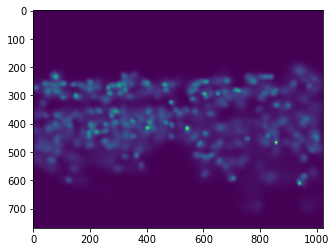

In [177]:
plt.imshow(Y_fs[0])
np.sum(Y_fs[0])

In [34]:
# FS: FULL SIZE
X_train, Y_train = X_fs_train, Y_fs_train
X_test, Y_test = X_fs_test, Y_fs_test

# DATA AUGMENTATION
print '\nMultiscale pyramidal'
print 'TRAIN:'
X_train, Y_train = multiscale_pyramidal(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = multiscale_pyramidal(X_test, Y_test)
print len(X_test), len(Y_test)

# PATCH SIZE
print '\nGenerate slices'
print 'TRAIN:'
X_train, Y_train = generate_slices(X_train, Y_train, slice_w=patch_w, slice_h=patch_h, offset=8)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = generate_slices(X_test, Y_test, slice_w=patch_w, slice_h=patch_h)
print len(X_test), len(Y_test)

print '\nFlip'
print 'TRAIN:'
X_train, Y_train = flip_slices(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = flip_slices(X_test, Y_test)
print len(X_test), len(Y_test)

print '\nSamples gt distribution correction'
print 'TRAIN:'
X_train, Y_train = samples_distribution(X_train, Y_train)
print len(X_train), len(Y_train)

print '\nShuffle'
print 'TRAIN:'
X_train, Y_train = shuffle_slices(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, y_test = shuffle_slices(X_test, Y_test)
print len(X_test), len(Y_test)


Multiscale pyramidal
TRAIN:
320 320
TEST:
80 80

Generate slices
TRAIN:
1165302 1165302
TEST:
535 535

Flip
TRAIN:
2330604 2330604
TEST:
1070 1070

Samples gt distribution correction
TRAIN:
32130 32130

Shuffle
TRAIN:
32130 32130
TEST:
1070 1070


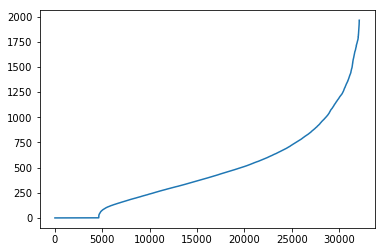

In [35]:
#Plot TRAIN samples distribution
Y_train_sum = filter(lambda x: True, map(np.sum, Y_train))
Y_train_sum.sort()
plt.plot(Y_train_sum)
plt.show()

In [36]:
def list_to_np_array(in_list):
    max_h = 0
    max_w = 0
    for i, item in enumerate(in_list):
        if item.shape[0] > max_h:
            max_h = item.shape[0]
        if item.shape[1] > max_w:
            max_w = item.shape[1]
    out_arr = np.zeros((len(in_list), max_h, max_w, 3))
    for i, item in enumerate(in_list):
        pad_h = max_h - item.shape[0]
        pad_w = max_w - item.shape[1]
        out_arr[i] = np.pad(item, ((0,pad_h),(0,pad_w),(0,0)), mode='constant', constant_values=0.)
    return out_arr

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=(30,30))
    plt.imshow(data)
    plt.axis('off')

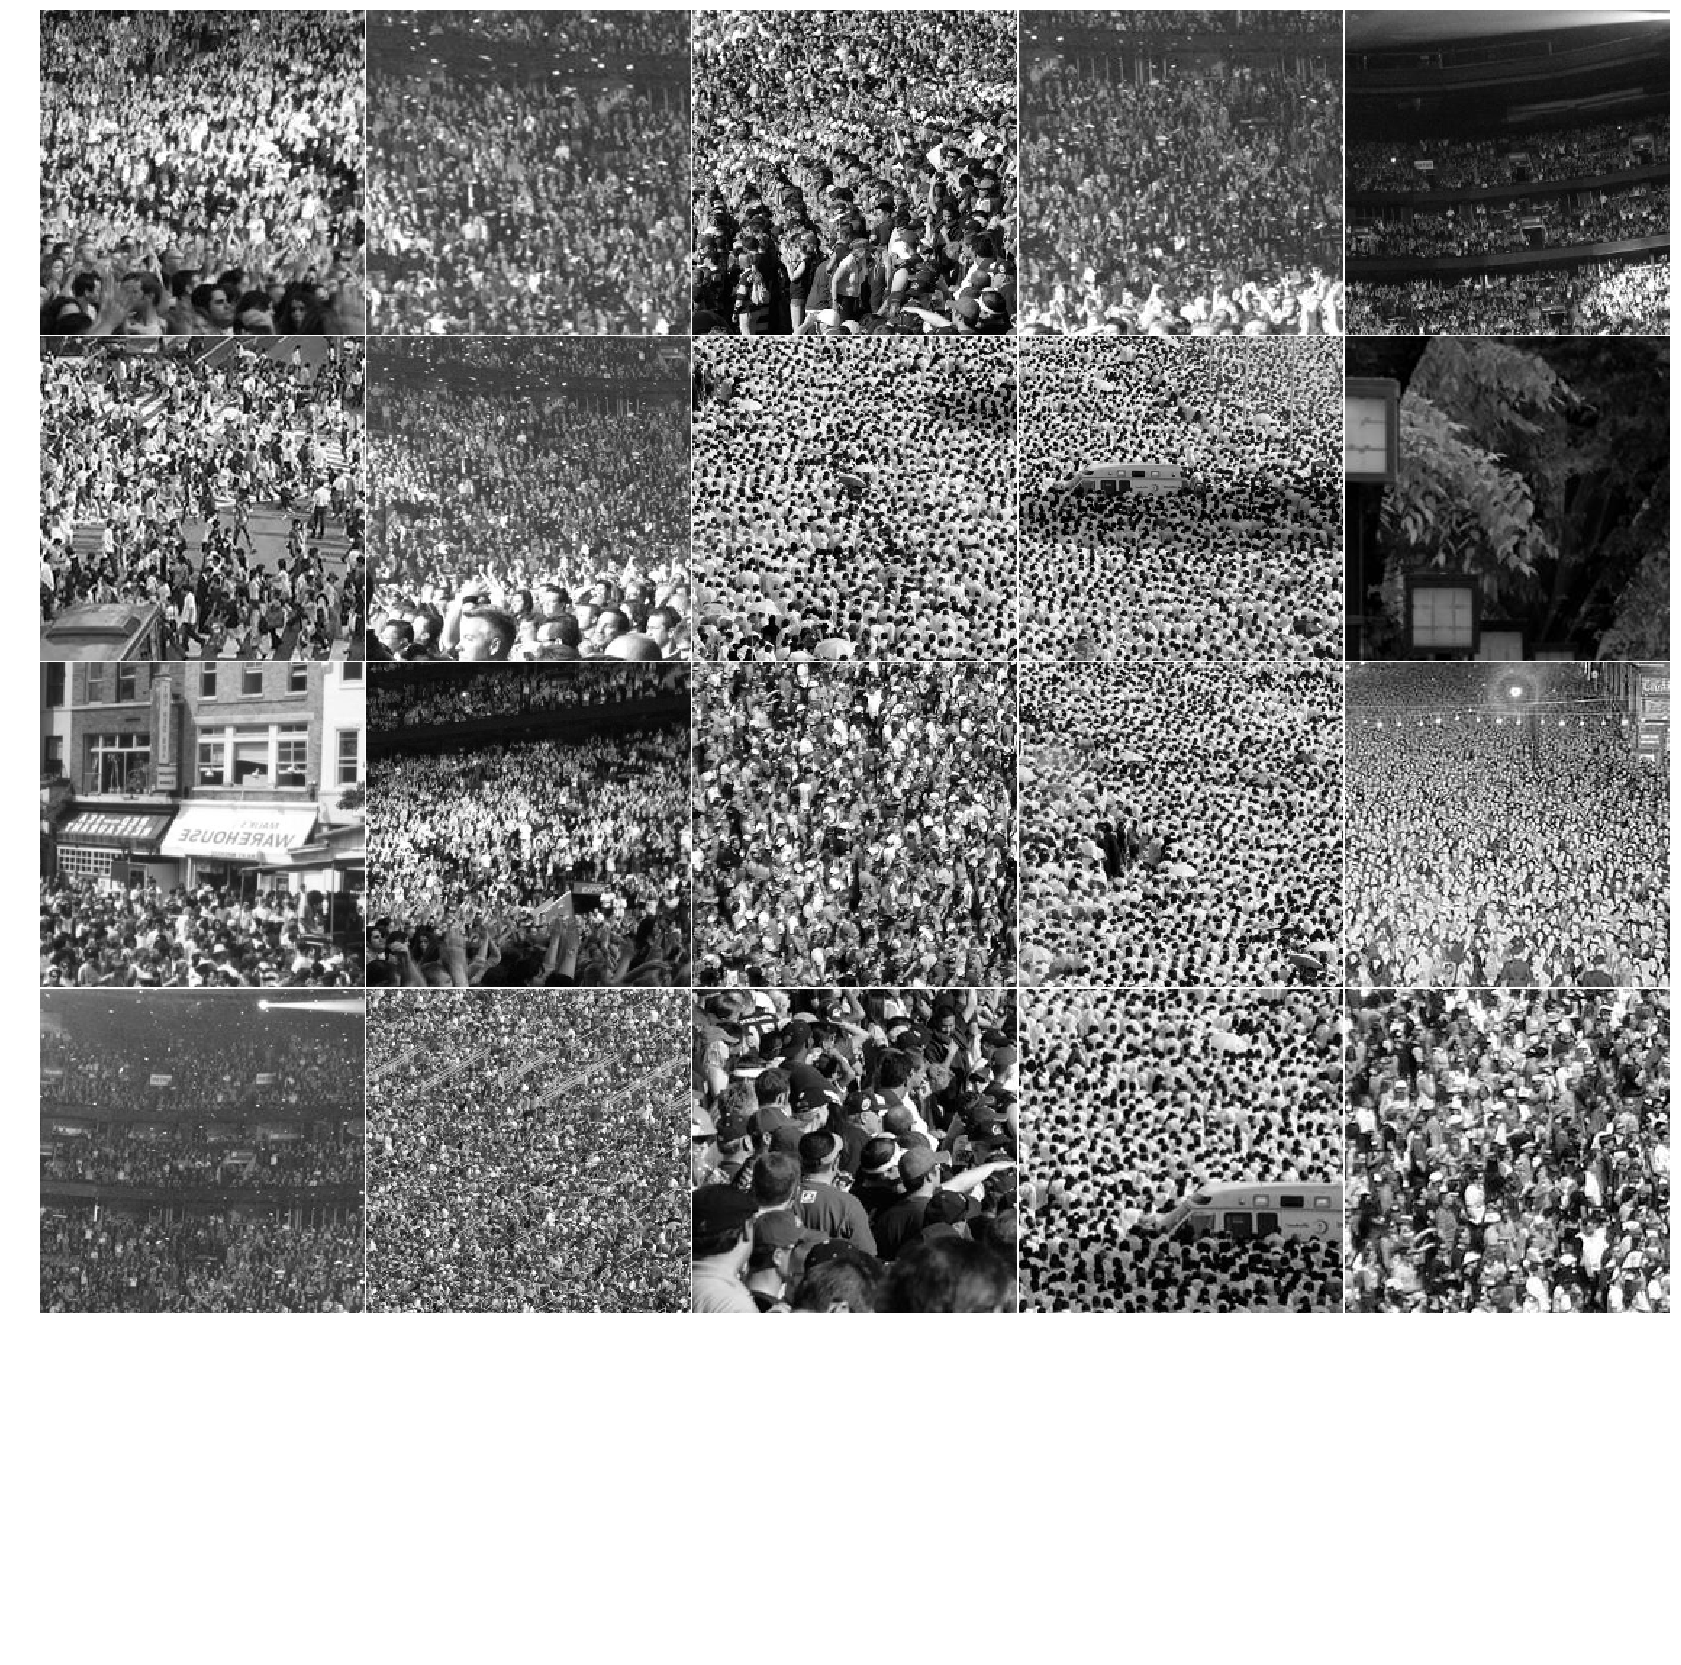

In [37]:
vis_square(list_to_np_array(X_train[:20]))

29595
494.468


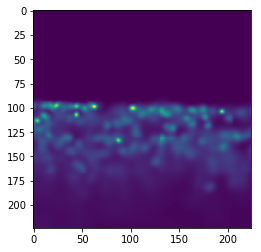

In [151]:
#visualize one random density
i = int(random.random()*len(Y_train))
print i
print np.sum(Y_train[i])
plt.imshow(Y_train[i])

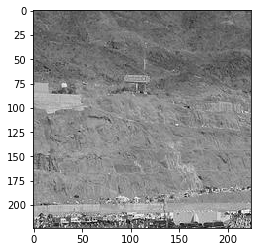

In [144]:
plt.imshow(X_train[i])

In [145]:
print(Y_train[i].shape)

(224, 224)


In [146]:
print(X_train[i][:,:,0].shape)

(224, 224)


In [147]:
def single_channel(img):
    img2=[]
    for i,k in enumerate(img):
        img2.append(k[:,:,0])
    return img2
def resize(img,fx=56,fy=56):
    imgr=[]
    for i,k in enumerate(img):
        imgr.append(cv2.resize(img[i],(fx,fy),interpolation=cv2.INTER_CUBIC)*16) #After resize times 16
    return imgr

In [148]:
X_train2=single_channel(X_train)
X_test2=single_channel(X_test)
Y_train2=resize(Y_train)
Y_test2=resize(Y_test)

In [157]:
print(X_train2[i].shape)
print(Y_train2[i].shape)

(224, 224)
(56, 56)


In [169]:
print(Y_train2[0].reshape(1,56,56))

[[[ 0.24335569  0.22042803  0.1762211  ...,  0.32402745  0.29748908
    0.33326918]
  [ 0.26207894  0.2205143   0.19082826 ...,  0.22413328  0.2080799
    0.21816429]
  [ 0.27250636  0.23814379  0.26603347 ...,  0.17615543  0.16926813
    0.15996806]
  ..., 
  [ 0.0104844   0.01364704  0.01716394 ...,  0.00492546  0.00357043
    0.00256432]
  [ 0.00985633  0.012862    0.01619209 ...,  0.00317762  0.00236826
    0.00182001]
  [ 0.00907174  0.01178557  0.01478595 ...,  0.0024606   0.00191967
    0.00156208]]]


In [174]:
def save(img,img_route,channels,height,width):
    env = lmdb.open(img_route, map_size=int(1e12))
    with env.begin(write=True) as txn:
        for i, k in enumerate(img):
                    datum = caffe.proto.caffe_pb2.Datum()
                    datum.channels = channels
                    datum.height = height
                    datum.width = width
                    datum.data = img[i].reshape(channels,height,width).tobytes() # or .tostring() if numpy < 1.9
                    datum.label = 0
                    str_id = '{:08}'.format(i)
                    txn.put(str_id.encode('ascii'), datum.SerializeToString())
    env.close()
def save_float(img,img_route,channels,height,width):
    env = lmdb.open(img_route, map_size=int(1e12))
    with env.begin(write=True) as txn:
        for i, k in enumerate(img):
                    datum = caffe.proto.caffe_pb2.Datum()
                    datum.channels = channels
                    datum.height = height
                    datum.width = width
                    datum.float_data.extend(img[i].reshape(channels,height,width).flat)
                    datum.label = 0
                    str_id = '{:08}'.format(i)
                    txn.put(str_id.encode('ascii'), datum.SerializeToString())
    env.close()

494.02


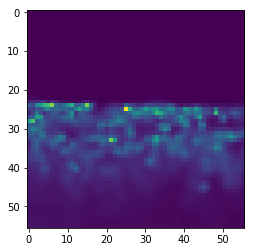

In [175]:
print np.sum(Y_train2[i])
plt.imshow(Y_train2[i])

In [176]:
print(Y_train2[i].shape)

(56, 56)


In [177]:
save_float(Y_train2,'/media/lee/New Volume/lyh/MCNN/YTRAIN_LMDB',1,56,56)
save_float(Y_test2,'/media/lee/New Volume/lyh/MCNN/YTEST_LMDB',1,56,56)
save(X_train2,'/media/lee/New Volume/lyh/MCNN/XTRAIN_LMDB',1,224,224)
save(X_test2,'/media/lee/New Volume/lyh/MCNN/XTEST_LMDB',1,224,224)

In [1]:
#train
#then find loss

In [46]:
import re
def draw_loss(dir):
    k=[]
    regex = "(loss = )[-+]?([0-9]*\.[0-9]+|[0-9]+)"
    regexobject = re.compile(regex)
    with open(dir) as file:
        line=file.readline()
        while line:
            #here add
            try:
                k.append(float(regexobject.search(line).group(2)))
            except:
                print 'Oops!'
            line=file.readline()
    return k
pt1_loss=draw_loss('/home/lee/Deep_Learning/MCNN/network/pretrain1.log')


Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

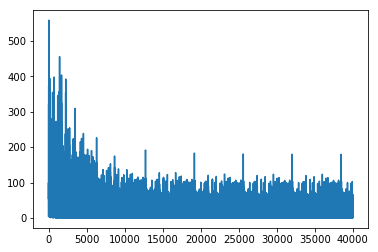

In [3]:
plt.plot(pt1_loss)

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops!
Oops

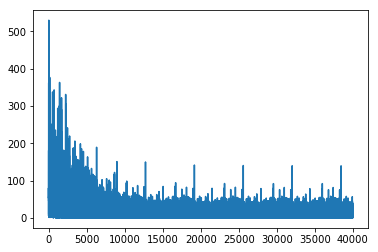

In [47]:
pt2_loss=draw_loss('/home/lee/Deep_Learning/MCNN/network/pretrain2.log')
plt.plot(pt2_loss)

In [4]:
#let's try pretrain1!

In [7]:
#read from lmdb
def read_int(dir,iter_size):
    env = lmdb.open(dir, readonly=True)
    data=[]
    for i in range(0,iter_size):        
        with env.begin() as txn:
            raw_datum = txn.get(b'%08d'%i)
        try:
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(raw_datum)
            flat_x = np.fromstring(datum.data, dtype=np.uint8)
            x = flat_x.reshape(datum.channels, datum.height, datum.width)
            data.append(x)
        except:
            break
    return data
def read_float(dir,iter_size):
    env = lmdb.open(dir, readonly=True)
    data=[]
    for i in range(0,iter_size):        
        with env.begin() as txn:
            raw_datum = txn.get(b'%08d'%i)
        try:
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(raw_datum)
            x = np.array(datum.float_data).astype(float).reshape( datum.channels, datum.height, datum.width)
            data.append(x)
        except:
            break
    return data    

In [8]:
test_data=read_int('/media/lee/New Volume/lyh/MCNN/XTEST_LMDB',1000000)
test_label=read_float('/media/lee/New Volume/lyh/MCNN/YTEST_LMDB',1000000)

In [9]:
test_data=np.asarray(test_data)
test_label=np.asarray(test_label)

In [10]:
print test_data.shape
print test_label.shape

(1070, 1, 224, 224)
(1070, 1, 56, 56)


In [12]:
caffe.set_mode_cpu()

model_def = '/home/lee/Deep_Learning/MCNN/network/pretrain1/deploy.prototxt'
model_weights = '/home/lee/Deep_Learning/MCNN/model/pretrain1/_iter_2000000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
def one_predict(img):
    # copy the image data into the memory allocated for the net
    net.blobs['data'].data[...] = img

    ### perform classification
    output = net.forward()

    output_prob = output['estdmap'][0]  # the output probability vector for the first image in the batch
    return output_prob

In [18]:
print np.sum(output_prob)

260.88


In [44]:
print np.sum(test_label[1])

312.541217313


In [26]:
def count_MAE(data,label):
    mae=0
    for i,k in enumerate(data):
        net.blobs['data'].data[...] = k
        output = net.forward()
        output_prob = output['estdmap'][0] 
        mae=mae+abs(np.sum(output_prob)-np.sum(label[i]))
    mae=mae/len(data)
    return mae

In [27]:
count_MAE(test_data,test_label)

142.77080596279342

In [34]:
np.rollaxis(output_prob,0,3).shape

(56, 56, 1)

In [8]:
def show(img):
    plt.imshow(np.rollaxis(img,0,3)[:,:,0])

In [ ]:
show(output_prob)

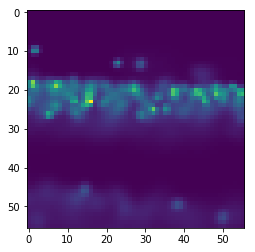

In [43]:
show(test_label[1])

In [1]:
#let's try pretrain2!

In [4]:
caffe.set_mode_gpu()

model_def = '/home/lee/Deep_Learning/MCNN/network/pretrain2/deploy.prototxt'
model_weights = '/home/lee/Deep_Learning/MCNN/model/pretrain2/_iter_2000000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

811.4021

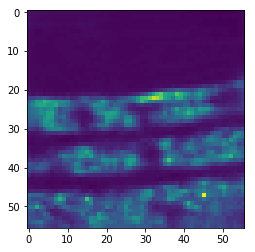

In [189]:
show(one_predict(training_data[4]))
np.sum(one_predict(training_data[4]))

212.51839743455253

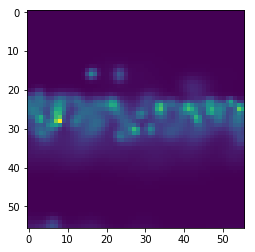

In [206]:
show(test_label[5])
np.sum(test_label[5])

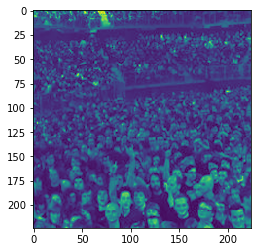

In [188]:
show(test_data[711])

In [33]:
#if there's error in trainning

In [43]:
training_data=read_int('/media/lee/New Volume/lyh/MCNN/XTRAIN_LMDB',1000000)
training_label=read_float('/media/lee/New Volume/lyh/MCNN/YTRAIN_LMDB',1000000)

In [44]:
training_data=np.asarray(training_data)
training_label=np.asarray(training_label)

In [46]:
print training_data.shape
print training_label.shape

(32130, 1, 224, 224)
(32130, 1, 56, 56)


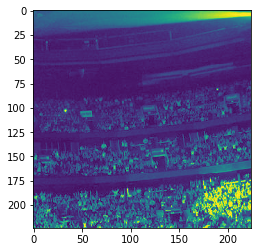

In [208]:
show(training_data[4])

831.45108955885655

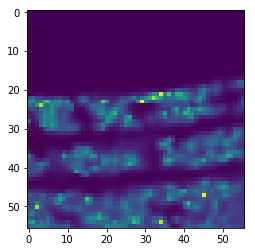

In [209]:
show(training_label[4])
np.sum(training_label[4])

In [ ]:
#nothing wrong...

In [ ]:
#creating large pic(we calculate the MAE)

In [7]:
def origin_resize(images, gts,f):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
            out_images.append(cv2.resize(img, None, fx=f, fy=f, interpolation = cv2.INTER_CUBIC))
            out_gts.append(density_resize(gts[i], fx=f, fy=f))
    return (out_images, out_gts)

In [8]:
out_X,out_Y=origin_resize(X_fs,Y_fs,0.5)

In [9]:
def trans_axis(images):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
            out_images.append(np.rollaxis(out_X[0],2,0)[0:1])
    return (out_images)    

In [10]:
tran_X=trans_axis(out_X)
print(len(tran_X))

50


In [11]:
print tran_X[0].shape

(1, 384, 512)


In [12]:
caffe.set_mode_gpu()

model_def = '/home/lee/Deep_Learning/MCNN/network/pretrain1/deploy.prototxt'
model_weights = '/home/lee/Deep_Learning/MCNN/model/pretrain1/_iter_2000000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [14]:
net.blobs['data'].reshape(1,        # batch size
                          1,         # 3-channel (BGR) images
                          384,  512)  # image size is 227x227

In [15]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = tran_X[0]

### perform classification
output = net.forward()

output_prob = output['estdmap'][0]  # the output probability vector for the first image in the batch


968.6756

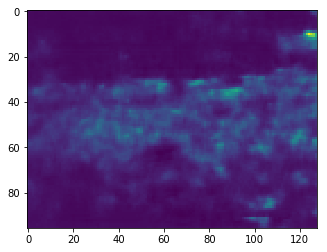

In [18]:
show(output_prob)
np.sum(output_prob)

1041.905

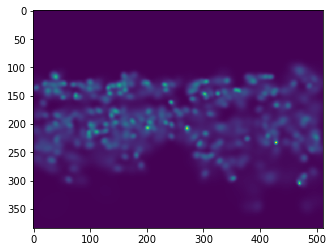

In [19]:
plt.imshow(out_Y[0])
np.sum(out_Y[0])

In [13]:
def test_MAE(define,weights,images,gt):
    MAE=0
    caffe.set_mode_gpu()
    model_def = define
    model_weights = weights
    net = caffe.Net(model_def,      # defines the structure of the model
                    model_weights,  # contains the trained weights
                    caffe.TEST)     # use test mode (e.g., don't perform dropout)
    for i,img in enumerate(images):
        net.blobs['data'].reshape(1,        # batch size
                          1,         # 3-channel (BGR) images
                          img.shape[1],  img.shape[2])  # image size is 227x227
        net.blobs['data'].data[...] = img
        output = net.forward()
        output_prob = output['estdmap'][0]  
        MAE=MAE+abs(np.sum(output_prob)-np.sum(gt[i]))
        print(np.sum(output_prob)-np.sum(gt[i]))
    MAE=MAE/len(images)
    return MAE

In [342]:
print(test_MAE('/home/lee/Deep_Learning/MCNN/network/pretrain1/deploy.prototxt',
                '/home/lee/Deep_Learning/MCNN/model/pretrain1/_iter_2000000.caffemodel',
               tran_X,out_Y))

-73.2294
-936.563
502.358
-447.426
272.41
247.409
390.113
-581.566
485.685
-1338.67
652.859
-881.69
723.781
-367.031
296.273
773.088
-3613.57
-1013.66
-736.168
548.307
21.0383
-2421.02
533.802
611.723
674.569
-964.487
-1980.92
-1692.47
-608.648
-1400.55
29.5605
-1122.76
-68.6545
343.85
-1380.74
221.193
598.908
293.001
-51.3171
877.49
-1360.42
-1570.9
818.498
-566.032
400.411
61.8588
426.652
-139.181
-287.787
86.1824
729.929645386


In [21]:
print(test_MAE('/home/lee/Deep_Learning/MCNN/network/pretrain2/deploy.prototxt',
                '/home/lee/Deep_Learning/MCNN/model/pretrain2/_iter_2000000.caffemodel',
               tran_X,out_Y))

-160.093
-1023.43
415.494
-534.289
185.547
160.545
303.25
-668.43
398.821
-1425.53
565.996
-968.553
636.917
-453.894
209.41
686.225
-3700.43
-1100.53
-823.031
461.443
-65.8252
-2507.88
446.939
524.859
587.705
-1051.35
-2067.78
-1779.33
-695.512
-1487.41
-57.303
-1209.63
-155.518
256.986
-1467.61
134.329
512.045
206.138
-138.181
790.627
-1447.29
-1657.76
731.635
-652.896
313.547
-25.0046
339.789
-226.044
-374.651
-0.68103
735.882193604


In [16]:
print(test_MAE('/home/lee/Deep_Learning/MCNN/network/pretrain3/deploy.prototxt',
                '/home/lee/Deep_Learning/MCNN/model/pretrain3/_iter_2000000.caffemodel',
               tran_X,out_Y))

-239.904
-1103.24
335.684
-614.1
105.736
80.7344
223.439
-748.241
319.01
-1505.34
486.185
-1048.36
557.106
-533.705
129.599
606.414
-3780.24
-1180.34
-902.842
381.633
-145.636
-2587.69
367.128
445.048
507.895
-1131.16
-2147.59
-1859.14
-775.323
-1567.23
-137.114
-1289.44
-235.329
177.176
-1547.42
54.5184
432.234
126.327
-217.991
710.816
-1527.1
-1737.57
651.824
-732.706
233.736
-104.816
259.978
-305.855
-454.462
-80.4919
748.651936035


In [ ]:
print(test_MAE('/home/lee/Deep_Learning/MCNN/network/MCNN/deploy.prototxt',
                '/home/lee/Deep_Learning/MCNN/model/MCNN/_iter_670000.caffemodel',
               tran_X,out_Y))